### Comparison of `MLP`, `Random-Search Tuned MLP`, `RandOver MLP`, `SPE MLP`

## The Method

1. Prepare data & Partition the data into 80-20 train-test split
2. Define Models & Parameters
3. Perform Cross-Validation on the training data
3. (Re)Train the models on the training data, either vanilla model or with best hyperparameters
4. Evaluate the (re)trained models on the test data
5. Final evaluation of the models

![The Method](method.png)

Source: [scikit-learn.org - Cross-validation](https://scikit-learn.org/1.5/modules/cross_validation.html#cross-validation-and-model-selection)

In [1]:
# Import libraries
import pandas as pd
import numpy as np
from pandas import DataFrame as df
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_validate
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as imblearn_pipeline # Use imblearn's pipeline
from sklearn.metrics import make_scorer, classification_report, precision_score, recall_score, f1_score
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Import ML libraries
import keras
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from imblearn.over_sampling import RandomOverSampler
from imbens.ensemble import SelfPacedEnsembleClassifier
from scikeras.wrappers import KerasClassifier
import keras_tuner
from keras import layers

from pprint import pprint
from time import time
import joblib

import warnings
warnings.filterwarnings('ignore')

RANDOM_STATE = 42
CROSS_VAL_SPLITS = 5
CKP_PREFIX = 'KDD_'

np.random.seed(RANDOM_STATE)

# pandas options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)


### 1. Prepare data & Partition the data into 80-20 train-test split

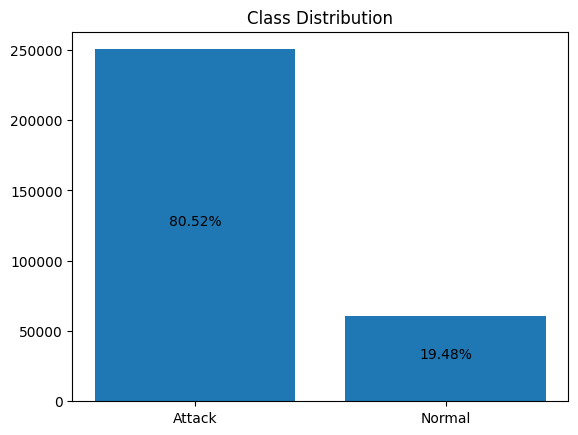

Weights:  {0: 4.991290198603437e-06, 1: 2.062961587655238e-05}
Transformed X_train shape: (248823, 121)


In [7]:
# Importing the dataset

path_to_data = '../data/kddcup/kddcup_data_corrected.csv'

# col names from https://kdd.ics.uci.edu/databases/kddcup99/kddcup.names
col_names = [
    "duration",
    "protocol_type",
    "service",
    "flag",
    "src_bytes",
    "dst_bytes",
    "land",
    "wrong_fragment",
    "urgent",
    "hot",
    "num_failed_logins",
    "logged_in",
    "num_compromised",
    "root_shell",
    "su_attempted",
    "num_root",
    "num_file_creations",
    "num_shells",
    "num_access_files",
    "num_outbound_cmds",
    "is_host_login",
    "is_guest_login",
    "count",
    "srv_count",
    "serror_rate",
    "srv_serror_rate",
    "rerror_rate",
    "srv_rerror_rate",
    "same_srv_rate",
    "diff_srv_rate",
    "srv_diff_host_rate",
    "dst_host_count",
    "dst_host_srv_count",
    "dst_host_same_srv_rate",
    "dst_host_diff_srv_rate",
    "dst_host_same_src_port_rate",
    "dst_host_srv_diff_host_rate",
    "dst_host_serror_rate",
    "dst_host_srv_serror_rate",
    "dst_host_rerror_rate",
    "dst_host_srv_rerror_rate",
    "label",
]
# from https://kdd.ics.uci.edu/databases/kddcup99/kddcup.names
categorical_cols = [
    "protocol_type",
    "service",
    "flag",
    "land",
    "logged_in",
    "is_host_login",
    "is_guest_login",
]

# Read data (10 % subset of the original dataset)
data = pd.read_csv(path_to_data, names=col_names, header=None)

# summarize attack types as "attack" for binary classification
data["label"] = data["label"].apply(lambda x: "attack" if x != "normal." else 'normal')

# Split data sets into X, y respectively
X = data.drop("label", axis=1)
y = data["label"]

# Visualize class imbalance
plt.bar(["Attack", "Normal"], data["label"].value_counts())
total = len(data)
fraud_percentage = (data["label"].value_counts()[1] / total) * 100
normal_percentage = (data["label"].value_counts()[0] / total) * 100

plt.text(0, data["label"].value_counts()[0] / 2, f'{normal_percentage:.2f}%', ha='center', color='black')
plt.text(1, data["label"].value_counts()[1] / 2, f'{fraud_percentage:.2f}%', ha='center', color='black')
plt.title("Class Distribution")
plt.show()

# Encode labels (LabelEncoder is not part of the pipeline but applied directly to y)
le = LabelEncoder()
y = le.fit_transform(y)

# create training and test partitions with 80-20 split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y)

# Fit OneHotEncoder to learn categories from the training data. This is necessary to ensure that the same categories are used for random splits during cross-validation
one_hot_encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False, dtype="int8")
one_hot_encoder.fit(X_train[categorical_cols])
learned_categories = one_hot_encoder.categories_

# Define numerical columns
num_cols = data.drop(categorical_cols, axis=1)

# Preprocessing pipeline for categorical and numerical data with fixed categories
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_cols.drop('label', axis=1).columns),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False, categories=learned_categories, dtype="int8"), categorical_cols)
    ]
)

# Set class weights
class_weight = {label[0]: 1.0 / count for label, count in df(y_train).value_counts().items()}
print("Weights: ", class_weight)

# Check preprocessing pipeline and get target shape
transformed_sample = preprocessor.fit_transform(X_train)
print(f"Transformed X_train shape: {transformed_sample.shape}")

### 2. Define models and parameters

In [8]:
## Credits for model architecture: https://keras.io/examples/structured_data/imbalanced_classification/
## Try same model architecture on this dataset for comparison
def _mlp(name="mlp"):
    # Hyperparameters
    data_dim = transformed_sample.shape[1] # Number of features after preprocessing pipeline step
    batch_size = 2048
    epochs = 50
    learning_rate = 1e-2
    Adam = keras.optimizers.Adam(learning_rate)

    # Define model
    model = keras.Sequential(
        [
            keras.Input(shape=(data_dim,)),
            keras.layers.Dense(256, activation="relu"),
            keras.layers.Dense(256, activation="relu"),
            keras.layers.Dropout(0.3),
            keras.layers.Dense(256, activation="relu"),
            keras.layers.Dropout(0.3),
            keras.layers.Dense(1, activation="sigmoid"),
        ]
    )

    # Define metrics
    metrics = [
        keras.metrics.F1Score(name="f1"),
        keras.metrics.Precision(name="precision"),
        keras.metrics.Recall(name="recall"),
    ]

    callbacks = [
        keras.callbacks.ModelCheckpoint(
            f"./ckp/{CKP_PREFIX}{name}/epoch_" + "{epoch}" + ".keras"
        )
    ]

    return KerasClassifier(
        model,
        epochs=epochs,
        batch_size=batch_size,
        verbose=0,
        loss="binary_crossentropy",
        callbacks=callbacks,
        metrics=metrics,
        optimizer=Adam,
        class_weight=class_weight,
        random_state=RANDOM_STATE,
    )


# Model for RandomSearchCV
def _random_search_mlp(
    input_units=256,
    input_activation="relu",
    dropout_input=False,
    dropout_input_rate=0.3,
    h1=False,
    h1_units=128,
    h1_activation="relu",
    dropout_h1=False,
    dropout_h1_rate=0.3,
    h2=False,
    h2_units=64,
    h2_activation="relu",
    dropout_h2=False,
    dropout_h2_rate=0.3,
    learning_rate=1e-2,
    name="rs_mlp",
    batch_size=2048,
    epochs=50,
):
    # print(f"Building model: {name}")
    # print('current params:', input_units, input_activation, dropout_input, dropout_input_rate, h1, h1_units, h1_activation, dropout_h1, dropout_h1_rate, h2, h2_units, h2_activation, dropout_h2, dropout_h2_rate, learning_rate, name, batch_size, epochs)
    data_dim = transformed_sample.shape[1] # Number of features after preprocessing pipeline step
    print(f"Input data shape for model: {data_dim}")

    model = keras.Sequential()
    model.add(layers.Input(shape=(data_dim,), name="input"))
    model.add(
        layers.Dense(input_units, activation=input_activation, name="input_layer")
    )

    if dropout_input:
        model.add(layers.Dropout(dropout_input_rate))

    if h1:
        model.add(layers.Dense(h1_units, activation=h1_activation, name="h1"))
        if dropout_h1:
            model.add(layers.Dropout(dropout_h1_rate))

    if h2:
        model.add(layers.Dense(h2_units, activation=h2_activation, name="h2"))
        if dropout_h2:
            model.add(layers.Dropout(dropout_h2_rate))

    model.add(layers.Dense(1, activation="sigmoid", name="output"))

    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
        loss="binary_crossentropy",
        metrics=[
            keras.metrics.F1Score(name="f1"),
            keras.metrics.Precision(name="precision"),
            keras.metrics.Recall(name="recall"),
        ],
    )
    return model


# KerasClassifier with create_model as build_fn
random_serach_keras_clf = KerasClassifier(
    build_fn=_random_search_mlp,
    verbose=0,
    random_state=RANDOM_STATE,
    input_units=256,
    optimizer=keras.optimizers.Adam(learning_rate=1e-2),
    loss="binary_crossentropy",
    input_activation="relu",
    dropout_input=False,
    dropout_input_rate=0.3,
    h1=False,
    h1_units=128,
    h1_activation="relu",
    dropout_h1=False,
    dropout_h1_rate=0.3,
    h2=False,
    h2_units=64,
    h2_activation="relu",
    dropout_h2=False,
    dropout_h2_rate=0.3,
    learning_rate=1e-2,
    name="rs_mlp",
    batch_size=2048,
    epochs=50,
    class_weight=class_weight,
)

# Define pipelines
mlp_normal_pipeline = Pipeline(
    [
        ('preprocessor', preprocessor),
        ("mlp", _mlp()),
    ]
)

# Define randomsearch pipeline
mlp_rs_pipeline = Pipeline(
    [
        ('preprocessor', preprocessor),
        ("rs_tuned_mlp", random_serach_keras_clf),
    ]
)

# Define multimetric scoring
scoring = {
    "f1": make_scorer(f1_score),
    "precision": make_scorer(precision_score),
    "recall": make_scorer(recall_score),
}

# Define parameter grid
parameter_grid = {
    "rs_tuned_mlp__input_units": [64, 128, 256],
    "rs_tuned_mlp__input_activation": ["relu", "tanh"],
    "rs_tuned_mlp__dropout_input": [True, False],
    "rs_tuned_mlp__dropout_input_rate": [0.1, 0.3, 0.5],
    "rs_tuned_mlp__h1": [True, False],
    "rs_tuned_mlp__h1_units": [64, 128, 256],
    "rs_tuned_mlp__h1_activation": ["relu", "tanh"],
    "rs_tuned_mlp__dropout_h1": [True, False],
    "rs_tuned_mlp__dropout_h1_rate": [0.1, 0.3, 0.5],
    "rs_tuned_mlp__h2": [True, False],
    "rs_tuned_mlp__h2_units": [64, 128, 256],
    "rs_tuned_mlp__h2_activation": ["relu", "tanh"],
    "rs_tuned_mlp__dropout_h2": [True, False],
    "rs_tuned_mlp__dropout_h2_rate": [0.1, 0.3, 0.5],
    "rs_tuned_mlp__learning_rate": [1e-2, 0.01, 0.02, 0.03],
}

# Randomized search with k-fold cross-validation
random_search = RandomizedSearchCV(
    estimator=mlp_rs_pipeline,
    param_distributions=parameter_grid,
    n_iter=10,  # Define the number of random samples to try
    scoring=scoring,
    refit="f1",  # Refit on F1 score after finding the best parameters
    cv=StratifiedKFold(n_splits=5),  # 5-fold cross-validation
    verbose=1,
    n_jobs=-1,
    random_state=RANDOM_STATE,
    error_score='raise',
)

### 3. Perform Cross-Validation on the training data

In [9]:
# Run random search on MLP and fit to training data
print("\nRunning RandomizedSearchCV for MLP...")
print("Hyperparameters to be evaluated:\n")
pprint(parameter_grid)

t0 = time()
random_search.fit(X_train, y_train)
print(
    f"\RandomizedSearchCV took {time() - t0:.2f} seconds ({(time() - t0) / 60:.2f} minutes)"
)

print("\nBest parameters combination found:")
best_parameters = random_search.best_estimator_.get_params()
for param_name in sorted(parameter_grid.keys()):
    print(f"{param_name}: {best_parameters[param_name]}")

# Best estimator from RandomizedSearchCV
best_mlp_model = random_search.best_estimator_

# save best model
joblib.dump(best_mlp_model, f"./saved/{CKP_PREFIX}best_mlp_model.pkl")



Running RandomizedSearchCV for MLP...
Hyperparameters to be evaluated:

{'rs_tuned_mlp__dropout_h1': [True, False],
 'rs_tuned_mlp__dropout_h1_rate': [0.1, 0.3, 0.5],
 'rs_tuned_mlp__dropout_h2': [True, False],
 'rs_tuned_mlp__dropout_h2_rate': [0.1, 0.3, 0.5],
 'rs_tuned_mlp__dropout_input': [True, False],
 'rs_tuned_mlp__dropout_input_rate': [0.1, 0.3, 0.5],
 'rs_tuned_mlp__h1': [True, False],
 'rs_tuned_mlp__h1_activation': ['relu', 'tanh'],
 'rs_tuned_mlp__h1_units': [64, 128, 256],
 'rs_tuned_mlp__h2': [True, False],
 'rs_tuned_mlp__h2_activation': ['relu', 'tanh'],
 'rs_tuned_mlp__h2_units': [64, 128, 256],
 'rs_tuned_mlp__input_activation': ['relu', 'tanh'],
 'rs_tuned_mlp__input_units': [64, 128, 256],
 'rs_tuned_mlp__learning_rate': [0.01, 0.01, 0.02, 0.03]}
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Input data shape for model: 121
Input data shape for model: 121
Input data shape for model: 121
Input data shape for model: 121
Input data shape for model: 121


/Users/i535223/devspace/venvs/ml/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/i535223/devspace/venvs/ml/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/i535223/devspace/venvs/ml/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/i535223/devspace/venvs/ml/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error i

Input data shape for model: 121


/Users/i535223/devspace/venvs/ml/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Input data shape for model: 121


/Users/i535223/devspace/venvs/ml/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Input data shape for model: 121


/Users/i535223/devspace/venvs/ml/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Input data shape for model: 121


/Users/i535223/devspace/venvs/ml/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Input data shape for model: 121


/Users/i535223/devspace/venvs/ml/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Input data shape for model: 121


/Users/i535223/devspace/venvs/ml/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Input data shape for model: 121


/Users/i535223/devspace/venvs/ml/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Input data shape for model: 121


/Users/i535223/devspace/venvs/ml/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Input data shape for model: 121


/Users/i535223/devspace/venvs/ml/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Input data shape for model: 121


/Users/i535223/devspace/venvs/ml/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Input data shape for model: 121


/Users/i535223/devspace/venvs/ml/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Input data shape for model: 121
Input data shape for model: 121


/Users/i535223/devspace/venvs/ml/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/i535223/devspace/venvs/ml/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Input data shape for model: 121


/Users/i535223/devspace/venvs/ml/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Input data shape for model: 121


/Users/i535223/devspace/venvs/ml/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Input data shape for model: 121


/Users/i535223/devspace/venvs/ml/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Input data shape for model: 121


/Users/i535223/devspace/venvs/ml/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Input data shape for model: 121


/Users/i535223/devspace/venvs/ml/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Input data shape for model: 121


/Users/i535223/devspace/venvs/ml/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Input data shape for model: 121


/Users/i535223/devspace/venvs/ml/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Input data shape for model: 121


/Users/i535223/devspace/venvs/ml/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Input data shape for model: 121


/Users/i535223/devspace/venvs/ml/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Input data shape for model: 121


/Users/i535223/devspace/venvs/ml/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Input data shape for model: 121


/Users/i535223/devspace/venvs/ml/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Input data shape for model: 121


/Users/i535223/devspace/venvs/ml/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Input data shape for model: 121


/Users/i535223/devspace/venvs/ml/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Input data shape for model: 121


/Users/i535223/devspace/venvs/ml/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Input data shape for model: 121


/Users/i535223/devspace/venvs/ml/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Input data shape for model: 121


/Users/i535223/devspace/venvs/ml/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Input data shape for model: 121


/Users/i535223/devspace/venvs/ml/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Input data shape for model: 121


/Users/i535223/devspace/venvs/ml/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Input data shape for model: 121


/Users/i535223/devspace/venvs/ml/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Input data shape for model: 121


/Users/i535223/devspace/venvs/ml/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Input data shape for model: 121


/Users/i535223/devspace/venvs/ml/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Input data shape for model: 121


/Users/i535223/devspace/venvs/ml/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Input data shape for model: 121


/Users/i535223/devspace/venvs/ml/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Input data shape for model: 121


/Users/i535223/devspace/venvs/ml/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Input data shape for model: 121


/Users/i535223/devspace/venvs/ml/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Input data shape for model: 121


/Users/i535223/devspace/venvs/ml/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Input data shape for model: 121
Input data shape for model: 121
\RandomizedSearchCV took 519.07 seconds (8.65 minutes)

Best parameters combination found:
rs_tuned_mlp__dropout_h1: True
rs_tuned_mlp__dropout_h1_rate: 0.5
rs_tuned_mlp__dropout_h2: False
rs_tuned_mlp__dropout_h2_rate: 0.5
rs_tuned_mlp__dropout_input: False
rs_tuned_mlp__dropout_input_rate: 0.1
rs_tuned_mlp__h1: False
rs_tuned_mlp__h1_activation: tanh
rs_tuned_mlp__h1_units: 128
rs_tuned_mlp__h2: True
rs_tuned_mlp__h2_activation: tanh
rs_tuned_mlp__h2_units: 64
rs_tuned_mlp__input_activation: relu
rs_tuned_mlp__input_units: 128
rs_tuned_mlp__learning_rate: 0.02


['./saved/KDD_best_mlp_model.pkl']

In [10]:
random_search.best_estimator_

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  Index(['duration', 'src_bytes', 'dst_bytes', 'wrong_fragment', 'urgent', 'hot',
       'num_failed_logins', 'num_compromised', 'root_shell', 'su_attempted',
       'num_root', 'num_file_creations', 'num_shells', 'num_access_files',
       'num_outbound_cmds', 'count', 'srv_count', 'serror_rate',
       'srv...
                 KerasClassifier(batch_size=2048, build_fn=<function _random_search_mlp at 0x32e2620c0>, class_weight={0: 4.991290198603437e-06, 1: 2.062961587655238e-05}, dropout_h1=True, dropout_h1_rate=0.5, dropout_h2=False, dropout_h2_rate=0.5, dropout_input=False, dropout_input_rate=0.1, epochs=50, h1=False, h1_activation='tanh', h1_units=128, h2=True, h2_activation='tanh', h2_units=64, input_activation='relu', input_units=128, learning_rate=0.02, loss='binary_crossentropy', name='rs_mlp', optimizer=<keras.src.optimizers.adam.Adam object at 0x3a49d91d0>, random_state=42, verbose=0))])

In [11]:
random_search.cv_results_

{'mean_fit_time': array([112.94750271, 186.21217852, 226.59421291,  70.44412284,
         42.58847923,  91.1659132 ,  46.88212128,  60.38853736,
         62.94483333,  41.34782515]),
 'std_fit_time': array([ 0.4792036 ,  8.27516406, 12.78120601, 17.02539807,  0.86298665,
         8.86312741,  2.01899701,  3.35714585,  5.36830192,  7.62046394]),
 'mean_score_time': array([1.15857949, 1.60471215, 1.04248762, 0.91123891, 0.24894795,
        0.33319602, 0.25049224, 0.28000126, 0.28403959, 0.21194129]),
 'std_score_time': array([0.27650992, 0.59088901, 0.77911462, 0.77873501, 0.00780244,
        0.02235328, 0.01476081, 0.0269484 , 0.01982576, 0.03106001]),
 'param_rs_tuned_mlp__learning_rate': masked_array(data=[0.02, 0.03, 0.01, 0.02, 0.02, 0.03, 0.01, 0.01, 0.02,
                    0.01],
              mask=[False, False, False, False, False, False, False, False,
                    False, False],
        fill_value='?',
             dtype=object),
 'param_rs_tuned_mlp__input_units': mas

In [21]:
# Get the index of the best combination found by RandomizedSearchCV
best_index = random_search.best_index_

# Extract mean and std for each metric from the best estimator
f1_mean = random_search.cv_results_['mean_test_f1'][best_index]
f1_std = random_search.cv_results_['std_test_f1'][best_index]

precision_mean = random_search.cv_results_['mean_test_precision'][best_index]
precision_std = random_search.cv_results_['std_test_precision'][best_index]

recall_mean = random_search.cv_results_['mean_test_recall'][best_index]
recall_std = random_search.cv_results_['std_test_recall'][best_index]

# Display results with mean ± std deviation format
print("\nRnadomSearchCV Cross-Validation Results:")
print(f"F1 Score: {f1_mean:.4f} ± {f1_std:.4f}")
print(f"Precision: {precision_mean:.4f} ± {precision_std:.4f}")
print(f"Recall: {recall_mean:.4f} ± {recall_std:.4f}")

# create pipeline
best_mlp_model_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ("best_mlp", best_mlp_model)
])


RnadomSearchCV Cross-Validation Results:
F1 Score: 0.9198 ± 0.0011
Precision: 0.8527 ± 0.0019
Recall: 0.9983 ± 0.0005


In [22]:
# 5-fold cross-validation for MLP Normal
print(f"{CROSS_VAL_SPLITS}-fold cross-validation for MLP Normal:")

mlp_scores = cross_validate(
    mlp_normal_pipeline, X_train, y_train, 
    cv=StratifiedKFold(n_splits=CROSS_VAL_SPLITS), scoring=scoring, n_jobs=-1
)
mlp_scores_df = pd.DataFrame(mlp_scores)

# Print mean ± standard deviation of scores
print("\nMLP Normal Cross-Validation Results:")
for metric in scoring.keys():
    mean_score = mlp_scores_df[f'test_{metric}'].mean()
    std_score = mlp_scores_df[f'test_{metric}'].std()
    print(f"{metric}: {mean_score:.4f} ± {std_score:.4f}")

5-fold cross-validation for MLP Normal:

MLP Normal Cross-Validation Results:
f1: 0.9195 ± 0.0015
precision: 0.8521 ± 0.0027
recall: 0.9986 ± 0.0004


In [31]:
# RandomSearch tuned MLP reports better results than the MLP architure used in the creditcard notebook
# So we will use the best model from RandomSearchCV for RandomOverSampler and SelfPacedEnsembleClassifier

# Define RandOver pipeline
mlp_randover_pipeline = imblearn_pipeline(
    [
       ('preprocessor', preprocessor),
        ("ros", RandomOverSampler(random_state=RANDOM_STATE)),
        ("randover_mlp", best_mlp_model),
    ]
)

# Define SPE pipeline
mlp_spe_pipeline = Pipeline(
    [
        ('preprocessor', preprocessor),
        ("spe_mlp", SelfPacedEnsembleClassifier(random_state=RANDOM_STATE, estimator=best_mlp_model)),
    ]
)

In [30]:
# Convert X_train to a DataFrame, since RandomOverSampler 
X_train_randover = X_train
if isinstance(X_train, np.ndarray):
    X_train_randover = pd.DataFrame(X_train, columns=col_names) 

# 5-fold cross-validation for Random Oversampling
print(f"\n{CROSS_VAL_SPLITS}-fold cross-validation for MLP Random Oversampling:")
ros_mlp_scores = cross_validate(
    mlp_randover_pipeline, X_train_randover, y_train,
    cv=StratifiedKFold(n_splits=CROSS_VAL_SPLITS), scoring=scoring, n_jobs=-1
)
ros_mlp_scores_df = pd.DataFrame(ros_mlp_scores)

print("\nRandom Oversampling:")
for metric in scoring.keys():
    mean_score = ros_mlp_scores_df[f'test_{metric}'].mean()
    std_score = ros_mlp_scores_df[f'test_{metric}'].std()
    print(f"{metric}: {mean_score:.4f} ± {std_score:.4f}")


5-fold cross-validation for MLP Random Oversampling:


ValueError: 
All the 5 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/i535223/devspace/venvs/ml/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/i535223/devspace/venvs/ml/lib/python3.11/site-packages/sklearn/base.py", line 1474, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/i535223/devspace/venvs/ml/lib/python3.11/site-packages/sklearn/pipeline.py", line 471, in fit
    Xt = self._fit(X, y, routed_params)
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/i535223/devspace/venvs/ml/lib/python3.11/site-packages/sklearn/pipeline.py", line 388, in _fit
    self._validate_steps()
  File "/Users/i535223/devspace/venvs/ml/lib/python3.11/site-packages/sklearn/pipeline.py", line 258, in _validate_steps
    raise TypeError(
TypeError: All intermediate steps should be transformers and implement fit and transform or be the string 'passthrough' 'RandomOverSampler(random_state=42)' (type <class 'imblearn.over_sampling._random_over_sampler.RandomOverSampler'>) doesn't


In [32]:
# 5-fold cross-validation for Self-Paced Ensemble

# Convert X_train to a DataFrame, since RandomOverSampler 
X_train_spe = X_train
if isinstance(X_train, np.ndarray):
    X_train_spe = pd.DataFrame(X_train, columns=col_names) 

print(f"\n{CROSS_VAL_SPLITS}-fold cross-validation for MLP Self-Paced Ensemble:")
spe_mlp_scores = cross_validate(
    mlp_spe_pipeline, X_train_spe, y_train, 
    cv=StratifiedKFold(n_splits=CROSS_VAL_SPLITS), scoring=scoring, n_jobs=-1
)
spe_mlp_scores_df = pd.DataFrame(spe_mlp_scores)

print("\nSelf-Paced Ensemble:")
for metric in scoring.keys():
    mean_score = spe_mlp_scores_df[f'test_{metric}'].mean()
    std_score = spe_mlp_scores_df[f'test_{metric}'].std()
    print(f"{metric}: {mean_score:.4f} ± {std_score:.4f}")


5-fold cross-validation for MLP Self-Paced Ensemble:


ValueError: 
All the 5 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/i535223/devspace/venvs/ml/lib/python3.11/site-packages/sklearn/utils/__init__.py", line 482, in _get_column_indices
    all_columns = X.columns
                  ^^^^^^^^^
AttributeError: 'numpy.ndarray' object has no attribute 'columns'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/i535223/devspace/venvs/ml/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/i535223/devspace/venvs/ml/lib/python3.11/site-packages/sklearn/base.py", line 1474, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/i535223/devspace/venvs/ml/lib/python3.11/site-packages/sklearn/pipeline.py", line 475, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "/Users/i535223/devspace/venvs/ml/lib/python3.11/site-packages/imbens/utils/_validation.py", line 604, in inner_f
    return f(**kwargs)
           ^^^^^^^^^^^
  File "/Users/i535223/devspace/venvs/ml/lib/python3.11/site-packages/imbens/ensemble/_under_sampling/self_paced_ensemble.py", line 245, in fit
    return super().fit(X, y, sample_weight=sample_weight, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/i535223/devspace/venvs/ml/lib/python3.11/site-packages/imbens/utils/_validation.py", line 604, in inner_f
    return f(**kwargs)
           ^^^^^^^^^^^
  File "/Users/i535223/devspace/venvs/ml/lib/python3.11/site-packages/imbens/ensemble/base.py", line 601, in fit
    return self._fit(X, y, sample_weight=sample_weight, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/i535223/devspace/venvs/ml/lib/python3.11/site-packages/imbens/utils/_validation.py", line 604, in inner_f
    return f(**kwargs)
           ^^^^^^^^^^^
  File "/Users/i535223/devspace/venvs/ml/lib/python3.11/site-packages/imbens/ensemble/_under_sampling/self_paced_ensemble.py", line 368, in _fit
    estimator.fit(X_resampled, y_resampled)
  File "/Users/i535223/devspace/venvs/ml/lib/python3.11/site-packages/sklearn/base.py", line 1474, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/i535223/devspace/venvs/ml/lib/python3.11/site-packages/sklearn/pipeline.py", line 471, in fit
    Xt = self._fit(X, y, routed_params)
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/i535223/devspace/venvs/ml/lib/python3.11/site-packages/sklearn/pipeline.py", line 408, in _fit
    X, fitted_transformer = fit_transform_one_cached(
                            ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/i535223/devspace/venvs/ml/lib/python3.11/site-packages/joblib/memory.py", line 312, in __call__
    return self.func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/i535223/devspace/venvs/ml/lib/python3.11/site-packages/sklearn/pipeline.py", line 1303, in _fit_transform_one
    res = transformer.fit_transform(X, y, **params.get("fit_transform", {}))
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/i535223/devspace/venvs/ml/lib/python3.11/site-packages/sklearn/utils/_set_output.py", line 295, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/i535223/devspace/venvs/ml/lib/python3.11/site-packages/sklearn/base.py", line 1474, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/i535223/devspace/venvs/ml/lib/python3.11/site-packages/sklearn/compose/_column_transformer.py", line 906, in fit_transform
    self._validate_column_callables(X)
  File "/Users/i535223/devspace/venvs/ml/lib/python3.11/site-packages/sklearn/compose/_column_transformer.py", line 496, in _validate_column_callables
    transformer_to_input_indices[name] = _get_column_indices(X, columns)
                                         ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/i535223/devspace/venvs/ml/lib/python3.11/site-packages/sklearn/utils/__init__.py", line 484, in _get_column_indices
    raise ValueError(
ValueError: Specifying the columns using strings is only supported for dataframes.


### 4. (Re)Train the models on the training data

In [ ]:
# Placeholder dictionary for training times
training_times = {}

# Retrain and time each model

# Train MLP Normal (optional)
start_time = time()
mlp_normal_pipeline.fit(X_train, y_train)
training_times['MLP Normal'] = time() - start_time

# Train best MLP model (from RandomSearchCV)
start_time = time()
best_mlp_model_pipeline.fit(X_train, y_train)
training_times['Best MLP (RandomSearchCV)'] = time() - start_time

# Train SPE MLP
start_time = time()
mlp_spe_pipeline.fit(X_train, y_train)
training_times['SPE MLP'] = time() - start_time

# Train Random Oversampling MLP
start_time = time()
mlp_randover_pipeline.fit(X_train, y_train)
training_times['Random Oversampling MLP'] = time() - start_time

# Report training times
print("Training Times for Each Model (in seconds):")
for model_name, training_time in training_times.items():
    print(f"{model_name}: {training_time:.2f} seconds")

### 5. Final evaluation of the models

In [ ]:
# evaluate each model on test set on f1, prec, recall and plot confusion matrix for each

# MLP Normal
y_test_pred = mlp_normal_pipeline.predict(X_test)
print("\nMLP Normal")
print(f"F-1 Score: {f1_score(y_test, y_test_pred):.4f}")
print(f"Precision: {precision_score(y_test, y_test_pred):.4f}")
print(f"Recall: {recall_score(y_test, y_test_pred):.4f}")

# Best MLP model (RandomSearchCV)
y_test_pred = best_mlp_model.predict(X_test)
print("\nBest MLP Model (RandomSearchCV)")
print(f"F-1 Score: {f1_score(y_test, y_test_pred):.4f}")
print(f"Precision: {precision_score(y_test, y_test_pred):.4f}")
print(f"Recall: {recall_score(y_test, y_test_pred):.4f}")

# SPE MLP
y_test_pred = mlp_spe_pipeline.predict(X_test)
print("\nSPE MLP")
print(f"F-1 Score: {f1_score(y_test, y_test_pred):.4f}")
print(f"Precision: {precision_score(y_test, y_test_pred):.4f}")
print(f"Recall: {recall_score(y_test, y_test_pred):.4f}")

# Random Oversampling MLP
y_test_pred = mlp_randover_pipeline.predict(X_test)
print("\nRandOver MLP")
print(f"F-1 Score: {f1_score(y_test, y_test_pred):.4f}")
print(f"Precision: {precision_score(y_test, y_test_pred):.4f}")
print(f"Recall: {recall_score(y_test, y_test_pred):.4f}")

# Plot confusion matrix for each model
fig, axs = plt.subplots(1, 4, figsize=(15, 5))
fig.suptitle("Confusion Matrices")
for i, model in enumerate([mlp_normal_pipeline, best_mlp_model, mlp_spe_pipeline, mlp_randover_pipeline]):
	y_test_pred = model.predict(X_test)
	cm = confusion_matrix(y_test, y_test_pred)
	disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Normal", "Fraud"])
	disp.plot(ax=axs[i])
	axs[i].set_title(model.steps[1][0])
plt.show()
